In [342]:
import warnings
warnings.filterwarnings("ignore")

import os 
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [343]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir,'train.csv')
test_data_path=join(data_dir,'test.csv')

train=pd.read_csv(train_data_path)
test=pd.read_csv(test_data_path)

In [344]:
train['date']=train['date'].apply(lambda i : i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [345]:
y=train['price']
del train['price']
del train['id']

In [346]:
test['date']=test['date'].apply(lambda i : i[:6]).astype(int)
del test['id']

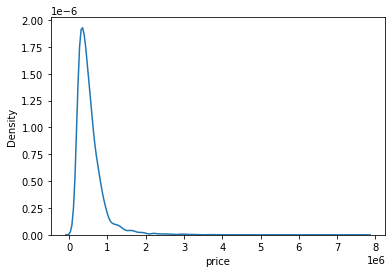

In [347]:
sns.kdeplot(y)
plt.show()

In [348]:
y=np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [349]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [350]:
def rmse(y_test,y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))

In [351]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [352]:
gboost= GradientBoostingRegressor(random_state=2020)
xgboost=XGBRegressor(random_state=2020)
lightgbm=LGBMRegressor(random_state=2020)
rdforest=RandomForestRegressor(random_state=2020)

models=[gboost, xgboost,lightgbm, rdforest]

In [353]:
def get_scores(models, train, y):
    df={}
    for model in models:
        model_name=model.__class__.__name__
        X_train,X_test,y_train,y_test=train_test_split(train,y,test_size=0.2,random_state=2020)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        df[model_name]=rmse(y_test,y_pred)
        score_df=pd.DataFrame(df,index=['RMSE']).T.sort_values('RMSE',ascending=False)
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [394]:
model=LGBMRegressor( learning_rate=0.1,n_estimators=100,num_leaves=31,num_iterations=1000,
    max_depth=-1,random_state=2020)

In [395]:
model2=XGBRegressor(learning_rate=0.1,n_estimators=100,gamma=0,subsample=1,colsample_bytree=1,
    max_depth=0,random_state=2020)

In [396]:
model3=RandomForestRegressor(n_estimators=500,
    max_depth=10,random_state=2020)

In [397]:
models=[model,model2,model3]
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m, X=x.values, y=y, cv=kfold))
        print(f"Model: {m}, CV score:{CV_score:.4f}")
get_cv_score(models)

Model: LGBMRegressor(num_iterations=1000, random_state=2020), CV score:0.9036
Model: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=1, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=0,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=1, tree_method=None,
             validate_parameters=None, verbosity=None), CV score:-0.0040
Model: RandomForestRegressor(max_depth=10, n_estimators=500, random_state=2020), CV score:0.8742


In [401]:
def AveragingBlending(models,train, y):
    for m in models : 
        m.fit(train, y)
    
    predictions = np.column_stack([
        m.predict(test) for m in models
    ])
    return np.mean(predictions, axis=1)
y_pred = AveragingBlending(models, train, y)
y_pred

array([13.08781496, 13.08765953, 13.72152637, ..., 13.04135808,
       12.84160908, 13.02280113])

In [402]:
def save_submission(model,model2,model3,train,y,test):
    model.fit(train,y)
    prediction=model.predict(test)
    prediction=np.expm1(prediction)
    model2.fit(train,y)
    prediction2=model2.predict(test)
    prediction2=np.expm1(prediction2)
    model3.fit(train,y)
    prediction3=model3.predict(test)
    prediction3=np.expm1(prediction3)
    cv_score=get_cv_score(models)
    y_pred=AveragingBlending(models,train,y)
    data_dir=os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path=join(data_dir,'sample_submission.csv')
    submission=pd.read_csv(submission_path)
    submission['price']=prediction
    submission_csv_path=('{}/submission_exploration.csv'.format(data_dir))
    submission.to_csv(submission_csv_path, index=False)

In [403]:
save_submission(model,model2,model3,train,y,test)

Model: LGBMRegressor(num_iterations=1000, random_state=2020), CV score:0.9036
Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None), CV score:-0.0040
Model: RandomForestRegressor(max_depth=10, n_estimators=500, random_state=2020), CV score:0.8742
